In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
path = "F:/for learn/Python_MachineLearning/"
df = pd.read_csv(path + "wdbc.data", header=None)

In [54]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [55]:
pipe_lr = Pipeline([("scaler", StandardScaler()), 
                    ('pca', PCA(n_components=2)),
                    ('lr', LogisticRegression(random_state=1, penalty='l2'))])

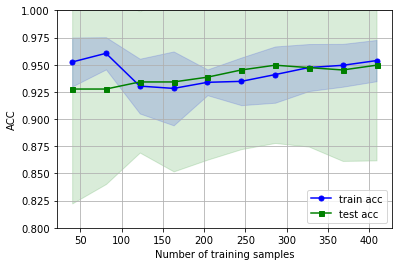

In [57]:
# 1. 绘制学习曲线
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                        X=X_train, 
                                                        y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10, 
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
colors = ['blue', 'green']
markers = ['o', 's']
for idx, dataType in enumerate(['train', 'test']):
    mean = eval(dataType + "_mean")
    std = eval(dataType + "_std")
    plt.plot(train_sizes, 
             mean, 
             color=colors[idx], 
             marker=markers[idx], 
             markersize=5, 
             label=dataType + " acc")
    plt.fill_between(train_sizes, 
                     mean + 3 * std, 
                     mean - 3 * std, 
                     alpha=0.15, 
                     color=colors[idx])
plt.grid()
plt.xlabel("Number of training samples")
plt.ylabel("ACC")
plt.legend(loc="lower right")
plt.ylim(0.8, 1.0)
plt.show()

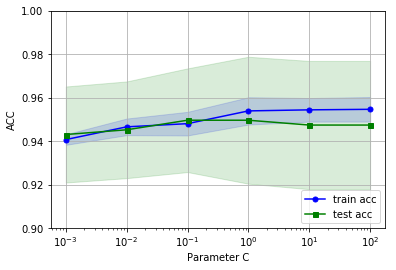

In [60]:
# 2. 参数验证曲线
param_range = np.power(10.0, range(-3, 3))
train_scores, test_scores = validation_curve(estimator=pipe_lr, 
                                             X=X_train, 
                                             y=y_train, 
                                             param_name='lr__C',
                                             param_range=param_range, 
                                             cv=10, 
                                             n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
colors = ['blue', 'green']
markers = ['o', 's']
for idx, dataType in enumerate(['train', 'test']):
    mean = eval(dataType + "_mean")
    std = eval(dataType + "_std")
    plt.plot(param_range, 
             mean, 
             color=colors[idx], 
             marker=markers[idx], 
             markersize=5, 
             label=dataType + " acc")
    plt.fill_between(param_range, 
                     mean + 1 * std, 
                     mean - 1 * std, 
                     alpha=0.15, 
                     color=colors[idx])
plt.grid()
plt.xscale('log')
plt.xlabel("Parameter C")
plt.ylabel("ACC")
plt.legend(loc="lower right")
plt.ylim(0.9, 1.0)
plt.show()

In [71]:
# 3. 参数网格搜索
pipe_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=1))])
param_range = np.power(10.0, range(-3, 4))
## 具体参数名称可以通过 pipe_svc.get_params().keys() 查看
## 因为 gamma参数只对kernel=’rbf‘起作用，所以为了减少计算次数，将参数grid分裂开
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']
              },
              {'svc__C': param_range, 
               'svc__kernel': ['rbf'],
               'svc__gamma': param_range
              }]
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'svc__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03]), 'svc__kernel': ['linear']}, {'svc__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03]), 'svc__kernel': ['rbf'], 'svc__gamma': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='ac

In [90]:
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'svc__C': 0.10000000000000001, 'svc__kernel': 'linear'}


In [93]:
best_pipe_svc = gs.best_estimator_
best_pipe_svc.fit(X_train, y_train)
print("the ACC of best pipe is: %.3f" % best_pipe_svc.score(X_test, y_test))

the ACC of best pipe is: 0.965


In [97]:
# 4. 嵌套交叉验证
# 用于模型选择
# 一共两层循环， 内层 GridSearch生成最优参数的 estimator， 外层做全部数据的 CV验证
# 之前做 GridSearch 时用的只是 X_train和 y_train，最终只能通过 X_test和 y_test进行验证。
# 这里所有数据都可以作为测试集进行验证，更好的评估不同 estimator（模型）之间的性能差距
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring="accuracy", 
                  cv=10, 
                  n_jobs=-1)
scores = cross_val_score(estimator=gs, X=X, y=y, scoring="accuracy", cv=5)
print("CV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV accuracy: 0.970 +/- 0.012


In [99]:
gs2 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                   param_grid=[{'max_depth': range(1, 8)}], 
                   scoring="accuracy", 
                   cv=10, 
                   n_jobs=-1)
scores2 = cross_val_score(estimator=gs2, X=X, y=y, scoring="accuracy", cv=5)
print("CV accuracy: %.3f +/- %.3f" % (np.mean(scores2), np.std(scores2)))

CV accuracy: 0.917 +/- 0.020
